In [1]:
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

DATA_DIR = (os.getcwd() + "/data/")
start_date = '1999-01-01'
end_date = "2019-12-31"
# Get fundamental data for each stock in the ticker and append to the dataframe


def get_all_symbols():
    return [v.strip('.csv') for v in os.listdir(DATA_DIR)]


tickers = get_all_symbols()


In [4]:
from tensorflow import keras


def build_models(X_train, y_train, sequence_length):

    # Grid Search for best parameters

    # Build the RNN model
    epochs = [50, 100]  # [50, 100]
    batch_sizes = [12, 24]  # [12, 24]
    results = {
        "epoch": [],
        "batch_size": [],
        "score": []
    }
    models = []
    for epoch in epochs:
        for batch_size in batch_sizes:
            
                model = keras.Sequential()
                model.add(keras.layers.LSTM(units=150, return_sequences=True,
                                            input_shape=(sequence_length, 1)))
                model.add(keras.layers.LSTM(units=75,  return_sequences=False))
                model.add(keras.layers.Dense(30))
                model.add(keras.layers.Dense(1))

                model.compile(optimizer='adam', loss='mean_squared_error')

                # Train the model
                model.fit(X_train, y_train, epochs=epoch,
                          batch_size=batch_size, verbose=0)
                models.append(model)
                score = model.evaluate(X_train, y_train, verbose=0)
                results["epoch"].append(epoch)
                results["batch_size"].append(batch_size)
                results["score"].append(score)
                print(
                    f"Epoch: {epoch} Batch Size: {batch_size} Score: {score}")

    # Return best model
    return models[np.argmin(results["score"])]


(3678, 5, 1) (3678, 1) (1577, 5, 1) (1577, 1)
Epoch: 50 Batch Size: 12 Score: 0.0015868060290813446
Epoch: 50 Batch Size: 24 Score: 0.001552482252009213
Epoch: 100 Batch Size: 12 Score: 0.0016401535831391811
Epoch: 100 Batch Size: 24 Score: 0.0016771176597103477
50/50 [==============================] - 1s 6ms/step
RMSE: 0.025945371711344367


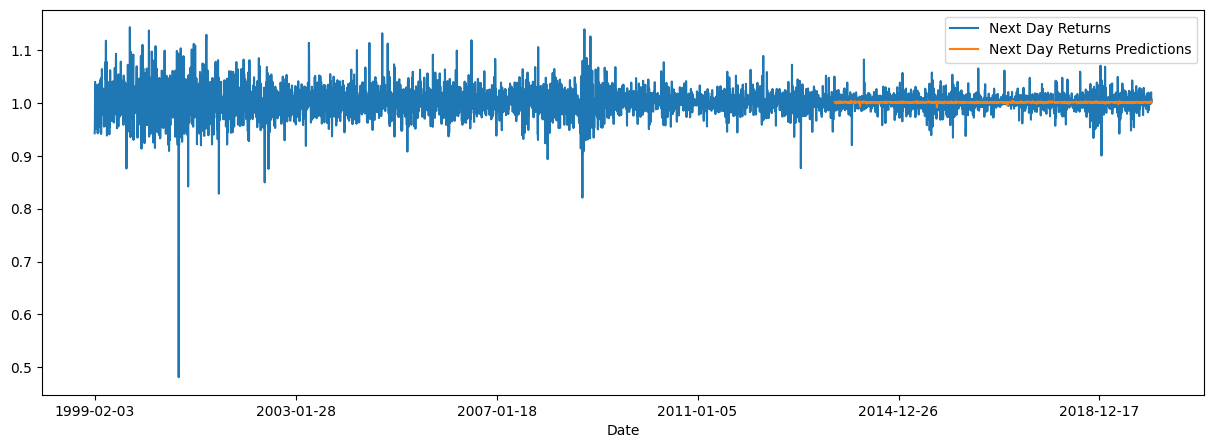

In [5]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from math import sqrt


tickers = ['AAPL']
for ticker in tickers:
    # Generate some example data
    ticker_data = pd.read_csv(f"data/{ticker}.csv", index_col=0)
    ticker_data['Next Day Returns'] = ticker_data['Returns'].shift(-1)
    ticker_data.dropna(inplace=True)
    
    returns = ticker_data['Next Day Returns'].values
    scaler = MinMaxScaler()
    returns = scaler.fit_transform(returns.reshape(-1, 1))

    # Define the sequence length and the number of time steps
    sequence_length = 5  # Number of past returns to consider for prediction
    n_steps = len(returns) - sequence_length

    X, y = [], []
    for i in range(n_steps):
        X.append(returns[i:i+sequence_length])
        y.append(returns[i+sequence_length])

    X = np.array(X)
    y = np.array(y)
    

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    model = build_models(X_train, y_train, sequence_length)
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Inverse transform the predictions if you used MinMaxScaler
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test)

    # Calculate the root mean squared error (RMSE)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse}")
    # Replace with your data loading code
    
    
    #Add the predictions to the dataframe only for the test data
    ticker_data['Next Day Returns Predictions'] = np.nan
    ticker_data.iloc[-len(y_pred):,
                     ticker_data.columns.get_loc('Next Day Returns Predictions')] = y_pred
    
    #Plot the predictions
    ticker_data[['Next Day Returns', 'Next Day Returns Predictions']].plot(
        figsize=(15, 5))
